In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap, LocallyLinearEmbedding

In [2]:
X = pd.read_csv("data/features_sp500.csv", index_col="created_utc", delimiter=";", encoding="utf-8")
X.head()

,title_polarity,title_subjectivity,submission_body_polarity,submission_body_subjectivity,submission_count,submission_score,upvote_ratio,comment_body_polarity,comment_body_subjectivity,comment_count,...,DD.2,buying,high,BUY,holding,GO,squeeze,BUYING,TENDIES,BAGHOLDER
created_utc,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7.303436,21.868398,6.478874,33.971240,104,104,0.0,130.939615,820.633747,2543.0,...,23.0,7.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
2020-01-02,4.819957,36.665525,0.440766,52.279186,139,2192,0.0,532.971197,4045.896734,12594.0,...,32.0,31.0,15.0,6.0,31.0,9.0,2.0,3.0,NaN,NaN
2020-01-03,4.492971,28.560375,5.997937,41.947068,115,36580,0.0,572.975674,5150.854530,16276.0,...,44.0,27.0,20.0,7.0,32.0,9.0,2.0,2.0,2.0,NaN
2020-01-04,1.844444,4.022222,0.093232,7.623026,28,16584,0.0,275.415978,1741.325526,5419.0,...,25.0,10.0,14.0,NaN,7.0,NaN,2.0,NaN,1.0,NaN
2020-01-05,1.537381,15.433770,4.989659,22.903422,67,460,0.0,253.327217,1925.347894,6162.0,...,21.0,11.0,9.0,2.0,13.0,1.0,NaN,NaN,NaN,NaN


In [3]:
y = pd.read_csv("data/SandP_500_withHighLow.csv", sep=",")
y = y[["Date", "Close", "Closing Movement"]]
y.set_index("Date", inplace=True)
y["created_utc"] = y.index
y.set_index("created_utc", inplace=True)
y.loc[(y['Closing Movement'] == -1),'Closing Movement'] = 0
y.head()

,Close,Closing Movement
created_utc,,
2017-02-28,218.594604,0
2017-03-01,221.654388,1
2017-03-02,220.258530,0
2017-03-03,220.397186,1
2017-03-06,219.740860,0


In [4]:
X = X.join(y, how='inner')
X = X.fillna(0)
X.head()

,title_polarity,title_subjectivity,submission_body_polarity,submission_body_subjectivity,submission_count,submission_score,upvote_ratio,comment_body_polarity,comment_body_subjectivity,comment_count,...,high,BUY,holding,GO,squeeze,BUYING,TENDIES,BAGHOLDER,Close,Closing Movement
created_utc,,,,,,,,,,,,,,,,,,,,,
2020-01-02,4.819957,36.665525,0.440766,52.279186,139,2192,0.0,532.971197,4045.896734,12594.0,...,15.0,6.0,31.0,9.0,2.0,3.0,0.0,0.0,317.873199,1
2020-01-03,4.492971,28.560375,5.997937,41.947068,115,36580,0.0,572.975674,5150.854530,16276.0,...,20.0,7.0,32.0,9.0,2.0,2.0,2.0,0.0,315.466217,0
2020-01-06,2.237558,26.646118,1.099999,47.910753,141,142,0.0,498.933519,4028.524789,12821.0,...,24.0,2.0,20.0,4.0,1.0,1.0,0.0,0.0,316.669739,1
2020-01-07,0.928602,33.124699,2.678287,58.454821,143,143,0.0,439.226358,4134.806548,13415.0,...,19.0,3.0,31.0,3.0,2.0,0.0,1.0,0.0,315.779327,0
2020-01-08,-4.471613,46.010141,5.871738,95.186840,226,226,0.0,560.857685,7624.799750,24207.0,...,21.0,5.0,43.0,12.0,4.0,1.0,1.0,0.0,317.462311,1


In [5]:
yr = X.pop("Close")
yc = X.pop("Closing Movement")
X.head()

,title_polarity,title_subjectivity,submission_body_polarity,submission_body_subjectivity,submission_count,submission_score,upvote_ratio,comment_body_polarity,comment_body_subjectivity,comment_count,...,DD.2,buying,high,BUY,holding,GO,squeeze,BUYING,TENDIES,BAGHOLDER
created_utc,,,,,,,,,,,,,,,,,,,,,
2020-01-02,4.819957,36.665525,0.440766,52.279186,139,2192,0.0,532.971197,4045.896734,12594.0,...,32.0,31.0,15.0,6.0,31.0,9.0,2.0,3.0,0.0,0.0
2020-01-03,4.492971,28.560375,5.997937,41.947068,115,36580,0.0,572.975674,5150.854530,16276.0,...,44.0,27.0,20.0,7.0,32.0,9.0,2.0,2.0,2.0,0.0
2020-01-06,2.237558,26.646118,1.099999,47.910753,141,142,0.0,498.933519,4028.524789,12821.0,...,57.0,28.0,24.0,2.0,20.0,4.0,1.0,1.0,0.0,0.0
2020-01-07,0.928602,33.124699,2.678287,58.454821,143,143,0.0,439.226358,4134.806548,13415.0,...,45.0,28.0,19.0,3.0,31.0,3.0,2.0,0.0,1.0,0.0
2020-01-08,-4.471613,46.010141,5.871738,95.186840,226,226,0.0,560.857685,7624.799750,24207.0,...,58.0,50.0,21.0,5.0,43.0,12.0,4.0,1.0,1.0,0.0


In [36]:
components = 10
model = LogisticRegression()

# define the pipeline
steps = {
    'Principle Component Analysis': [('pca', PCA(n_components=components)), ('m', model)],
    'Singular Value Decomposition': [('svd', TruncatedSVD(n_components=components)), ('m', model)],
    'Linear Discriminant Analysis': [('lda', LinearDiscriminantAnalysis(n_components=1)), ('m', model)],
    'Isomap Embedding': [('iso', Isomap(n_components=components)), ('m', model)],
    'Locally Linear Embedding': [('lle', LocallyLinearEmbedding(n_components=components)), ('m', model)],
    'Modified Locally Linear Embedding': [('mlle', LocallyLinearEmbedding(n_components=components, method='modified', n_neighbors=components)), ('m', model)]
}

for key in steps.keys():
    model = Pipeline(steps=steps[key])
    
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X, yc.values, scoring='accuracy', cv=cv, n_jobs=-1)
    
    # report performance
    print('%s: %.3f (%.3f)' % (key, np.mean(n_scores), np.std(n_scores)))

Principle Component Analysis: 0.562 (0.076)
Singular Value Decomposition: 0.566 (0.047)
Linear Discriminant Analysis: 0.467 (0.075)
Isomap Embedding: 0.513 (0.090)
Locally Linear Embedding: 0.567 (0.021)
Modified Locally Linear Embedding: 0.573 (0.015)


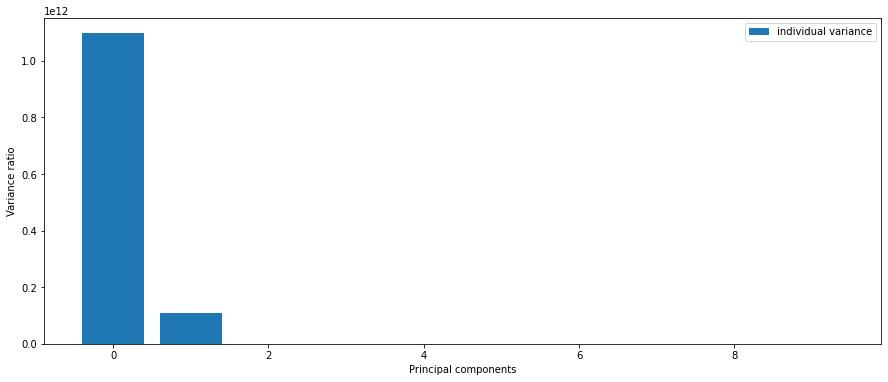

In [39]:
# visualize
pca = PCA(n_components=10)
pca.fit_transform(X)
pca_variance = pca.explained_variance_

plt.figure(figsize=(15, 6))
plt.bar(range(10), pca_variance[:10], align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

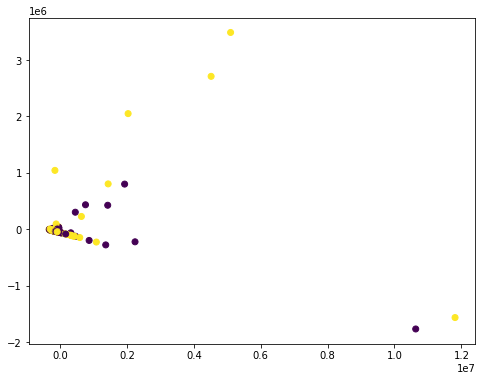

In [40]:
pca2 = PCA(n_components=10)
pca2.fit(X)
x = pca2.transform(X)

plt.figure(figsize=(8,6))
plt.scatter(x[:,0], x[:,1], c=yc)
plt.show()